In [1]:
import pickle
import pandas as pd
import itertools
from collections import Counter
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
import os
import string
import re
import tqdm

from collections import defaultdict
from math import log, sqrt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from numpy import linalg as LA
from gensim.models import Word2Vec, LdaModel
from gensim.corpora import Dictionary

import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#added:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_train = pd.read_csv('drugsComTrain_raw.tsv',sep = '\t')
data_test = pd.read_csv('drugsComTest_raw.tsv',sep = '\t')

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
def preprocess_df(df):
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["review"].lower()
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [lemmatizer.lemmatize(word) for word in words_list if word not in stop_words and len(word) != 1]
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    df = df[df["text"] != '']
    return df

In [5]:
data_train = preprocess_df(data_train)
data_test = preprocess_df(data_test)

In [6]:
def s_to_b(x):
    if x >=7:
        return 1
    elif x >=4 and x<=7:
        return 0
    else:
        return -1

data_train['sentiment'] = data_train['rating'].apply(lambda x : s_to_b(x))
data_test['sentiment'] = data_test['rating'].apply(lambda x : s_to_b(x))

In [7]:
y_train = data_train['sentiment']
y_test = data_test['sentiment']

# CountVectorizer

In [20]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data_train["text"])
X_test_counts = count_vect.transform(data_test["text"])

In [23]:
clf = LogisticRegression(random_state=1234, max_iter=10000)
param_grid = {"C": [30, 20, 10, 5, 1, 0.1]}
lr_cv = GridSearchCV(
    clf, param_grid, scoring="accuracy", cv=5, n_jobs=4, verbose=5
).fit(X_train_counts, y_train)
print(lr_cv.best_params_)
print(lr_cv.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'C': 5}
0.7927211854423709


In [24]:
y_pred = lr_cv.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.74      0.71      0.72     11838
           0       0.54      0.37      0.44      6488
           1       0.86      0.92      0.89     35437

    accuracy                           0.81     53763
   macro avg       0.71      0.67      0.68     53763
weighted avg       0.79      0.81      0.80     53763



In [29]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_counts, y_train)

y_pred = naive_bayes_classifier.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.62      0.63     11838
           0       0.31      0.31      0.31      6488
           1       0.83      0.84      0.83     35437

    accuracy                           0.73     53763
   macro avg       0.59      0.59      0.59     53763
weighted avg       0.72      0.73      0.72     53763



In [30]:
sgd_clf = SGDClassifier() #loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42
sgd_clf.fit(X_train_counts, y_train)
y_pred = sgd_clf.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.70      0.65      0.67     11838
           0       0.55      0.09      0.16      6488
           1       0.81      0.95      0.87     35437

    accuracy                           0.78     53763
   macro avg       0.68      0.56      0.57     53763
weighted avg       0.75      0.78      0.74     53763



In [10]:
count_vect = CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(data_train["text"])
X_test_counts = count_vect.transform(data_test["text"])

lr = LogisticRegression(random_state=1234, max_iter=10000)
lr.fit(X_train_counts, y_train)
y_pred = lr.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.86      0.87     11838
           0       0.84      0.67      0.74      6488
           1       0.93      0.97      0.95     35437

    accuracy                           0.91     53763
   macro avg       0.88      0.83      0.85     53763
weighted avg       0.90      0.91      0.90     53763



In [11]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_counts, y_train)

y_pred = naive_bayes_classifier.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.69      0.77     11838
           0       0.98      0.32      0.48      6488
           1       0.83      0.98      0.90     35437

    accuracy                           0.84     53763
   macro avg       0.89      0.67      0.72     53763
weighted avg       0.85      0.84      0.82     53763



In [12]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_counts, y_train)
y_pred = sgd_clf.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.83      0.85     11838
           0       0.85      0.58      0.69      6488
           1       0.90      0.97      0.94     35437

    accuracy                           0.89     53763
   macro avg       0.87      0.79      0.82     53763
weighted avg       0.89      0.89      0.89     53763



In [9]:
count_vect = CountVectorizer(ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(data_train["text"])
X_test_counts = count_vect.transform(data_test["text"])

In [10]:
lr = LogisticRegression(random_state=1234, max_iter=10000)
lr.fit(X_train_counts, y_train)
y_pred = lr.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.87      0.87     11838
           0       0.88      0.65      0.75      6488
           1       0.93      0.97      0.95     35437

    accuracy                           0.91     53763
   macro avg       0.89      0.83      0.86     53763
weighted avg       0.91      0.91      0.91     53763



In [ ]:
# clf = LogisticRegression(random_state=1234, max_iter=10000)
# param_grid = {"C": [30, 20, 10, 5, 1, 0.1]}
# lr_cv = GridSearchCV(
#     clf, param_grid, scoring="accuracy", cv=5, n_jobs=4, verbose=5
# ).fit(X_train_counts, y_train)
# print(lr_cv.best_params_)
# print(lr_cv.best_score_)
# y_pred = lr_cv.predict(X_test_counts)
# print(metrics.classification_report(y_test, y_pred))

In [13]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_counts, y_train)
y_pred = naive_bayes_classifier.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.66      0.78     11838
           0       1.00      0.53      0.70      6488
           1       0.84      1.00      0.91     35437

    accuracy                           0.87     53763
   macro avg       0.93      0.73      0.80     53763
weighted avg       0.88      0.87      0.86     53763



In [14]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_counts, y_train)
y_pred = sgd_clf.predict(X_test_counts)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.86      0.86     11838
           0       0.91      0.63      0.74      6488
           1       0.92      0.97      0.94     35437

    accuracy                           0.91     53763
   macro avg       0.90      0.82      0.85     53763
weighted avg       0.90      0.91      0.90     53763



# TF-IDF

In [13]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(data_train["text"])
X_test_tf = tf_idf.transform(data_test["text"])

In [18]:
clf = LogisticRegression(random_state=1234, max_iter=10000)
param_grid = {"C": [30, 20, 10, 5, 1, 0.1]}
lr_cv = GridSearchCV(
    clf, param_grid, scoring="accuracy", cv=5, n_jobs=4, verbose=5
).fit(X_train_tf, y_train)
print(lr_cv.best_params_)
print(lr_cv.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'C': 30}
0.793520987041974


In [19]:
y_pred = lr_cv.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.73      0.71      0.72     11838
           0       0.52      0.34      0.41      6488
           1       0.86      0.92      0.89     35437

    accuracy                           0.80     53763
   macro avg       0.70      0.66      0.67     53763
weighted avg       0.79      0.80      0.79     53763



In [14]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)
y_pred = naive_bayes_classifier.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.15      0.26     11838
           0       1.00      0.00      0.00      6488
           1       0.68      1.00      0.81     35437

    accuracy                           0.69     53763
   macro avg       0.85      0.38      0.36     53763
weighted avg       0.76      0.69      0.59     53763



In [15]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_tf, y_train)
y_pred = sgd_clf.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.72      0.53      0.61     11838
           0       1.00      0.00      0.00      6488
           1       0.76      0.97      0.85     35437

    accuracy                           0.76     53763
   macro avg       0.83      0.50      0.49     53763
weighted avg       0.78      0.76      0.70     53763



In [16]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2))
X_train_tf = tf_idf.fit_transform(data_train["text"])
X_test_tf = tf_idf.transform(data_test["text"])

In [17]:
lr = LogisticRegression(random_state=1234, max_iter=10000)
lr.fit(X_train_tf, y_train)
y_pred = lr.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.80      0.74      0.77     11838
           0       0.76      0.24      0.36      6488
           1       0.84      0.97      0.90     35437

    accuracy                           0.83     53763
   macro avg       0.80      0.65      0.68     53763
weighted avg       0.82      0.83      0.81     53763



In [17]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)
y_pred = naive_bayes_classifier.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.99      0.01      0.02     11838
           0       0.00      0.00      0.00      6488
           1       0.66      1.00      0.80     35437

    accuracy                           0.66     53763
   macro avg       0.55      0.34      0.27     53763
weighted avg       0.65      0.66      0.53     53763



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_tf, y_train)
y_pred = sgd_clf.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.82      0.35      0.49     11838
           0       0.00      0.00      0.00      6488
           1       0.72      0.99      0.83     35437

    accuracy                           0.73     53763
   macro avg       0.51      0.45      0.44     53763
weighted avg       0.66      0.73      0.66     53763



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tf = tf_idf.fit_transform(data_train["text"])
X_test_tf = tf_idf.transform(data_test["text"])

In [23]:
lr = LogisticRegression(random_state=1234, max_iter=10000)
lr.fit(X_train_tf, y_train)
y_pred = lr.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.75      0.79     11838
           0       0.81      0.25      0.38      6488
           1       0.84      0.97      0.90     35437

    accuracy                           0.84     53763
   macro avg       0.82      0.66      0.69     53763
weighted avg       0.83      0.84      0.81     53763



In [ ]:
# clf = LogisticRegression(random_state=1234, max_iter=10000)
# param_grid = {"C": [30, 20, 10, 5, 1, 0.1]}
# lr_cv = GridSearchCV(
#     clf, param_grid, scoring="accuracy", cv=5, n_jobs=4, verbose=5
# ).fit(X_train_tf, y_train)
# print(lr_cv.best_params_)
# print(lr_cv.best_score_)
# y_pred = lr_cv.predict(X_test_tf)
# print(metrics.classification_report(y_test, y_pred))

In [21]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)
y_pred = naive_bayes_classifier.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.98      0.00      0.01     11838
           0       0.00      0.00      0.00      6488
           1       0.66      1.00      0.79     35437

    accuracy                           0.66     53763
   macro avg       0.55      0.33      0.27     53763
weighted avg       0.65      0.66      0.53     53763



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_tf, y_train)
y_pred = sgd_clf.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.88      0.15      0.26     11838
           0       0.00      0.00      0.00      6488
           1       0.68      1.00      0.81     35437

    accuracy                           0.69     53763
   macro avg       0.52      0.38      0.36     53763
weighted avg       0.64      0.69      0.59     53763



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Word2vec

In [27]:
tagged_train_data = [word_tokenize(_d) for i, _d in enumerate(data_train["text"])]
tagged_test_data = [word_tokenize(_d) for i, _d in enumerate(data_test["text"])]

In [21]:
def build_vocab(sentences):
    word_counts = Counter(itertools.chain(*sentences))
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

In [22]:
tagged_data = [word_tokenize(_d) for i, _d in enumerate(data_train["text"])]
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]

In [23]:
def get_embeddings(inp_data, vocabulary_inv, size_features=100,
                   mode='skipgram',
                   min_word_count=2,
                   context=5):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15
    downsampling = 1e-3
    print('Training Word2Vec model...')
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    if mode == 'skipgram':
        sg = 1
        print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
        print('Model: CBOW')
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=sg,
                                        vector_size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling)
    print("Saving Word2Vec model {}".format(model_name))
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
    return embedding_weights

In [25]:
#embedding_weights = get_embeddings(inp_data, vocabulary_inv)
embedding_weights = get_embeddings(inp_data, vocabulary_inv,size_features=700,context=20)

Training Word2Vec model...
Model: skip-gram
Saving Word2Vec model embedding


In [28]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)

In [29]:
test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    test_vec.append(vec)

In [30]:
clf = LogisticRegression(random_state=1234, max_iter=10000)
clf.fit(train_vec, y_train)
y_pred = clf.predict(test_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.67      0.60      0.63     11838
           0       0.36      0.05      0.09      6488
           1       0.79      0.94      0.86     35437

    accuracy                           0.76     53763
   macro avg       0.60      0.53      0.53     53763
weighted avg       0.71      0.76      0.71     53763



In [26]:
clf = LogisticRegression(random_state=1234, max_iter=10000)
param_grid = {"C": [20, 10, 5, 1, 0.1]}
lr_cv = GridSearchCV(
    clf, param_grid, scoring="accuracy", cv=5, n_jobs=4, verbose=5
).fit(train_vec, y_train)
print(lr_cv.best_params_)
print(lr_cv.best_score_) # 200d：0.7520 # 200d,lem:0.7461 # 100d: 0.7443 # 100d not lower 0.7446 # 300d,1:0.7556 #300d,2:0.7548 #300d,2,:0.7567

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 20}
0.7461528923057846


In [27]:
y_pred = lr_cv.predict(test_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.56      0.60     11838
           0       0.36      0.03      0.06      6488
           1       0.77      0.94      0.85     35437

    accuracy                           0.75     53763
   macro avg       0.59      0.51      0.50     53763
weighted avg       0.70      0.75      0.70     53763



# LSTM

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [11]:
lb=LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [12]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_train['text'].values)
X_train = tokenizer.texts_to_sequences(data_train['text'].values)
X_train = pad_sequences(X_train)
X_test = tokenizer.texts_to_sequences(data_test['text'].values)
X_test = pad_sequences(X_test)

In [13]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
2521/2521 [==============================] - 6494s 3s/step - loss: 0.7125 - accuracy: 0.7179 - val_loss: 0.6404 - val_accuracy: 0.7439
Epoch 2/10
2521/2521 [==============================] - 6316s 3s/step - loss: 0.6390 - accuracy: 0.7460 - val_loss: 0.6201 - val_accuracy: 0.7530
Epoch 3/10
2521/2521 [==============================] - 6480s 3s/step - loss: 0.6146 - accuracy: 0.7542 - val_loss: 0.6036 - val_accuracy: 0.7576
Epoch 4/10
2521/2521 [==============================] - 6510s 3s/step - loss: 0.5977 - accuracy: 0.7615 - val_loss: 0.5954 - val_accuracy: 0.7634
Epoch 5/10
2521/2521 [==============================] - 6496s 3s/step - loss: 0.5817 - accuracy: 0.7682 - val_loss: 0.5803 - val_accuracy: 0.7685
Epoch 6/10
2521/2521 [==============================] - 6515s 3s/step - loss: 0.5680 - accuracy: 0.7738 - val_loss: 0.5733 - val_accuracy: 0.7711
Epoch 7/10
2521/2521 [==============================] - 6476s 3s/step - loss: 0.5539 - accuracy: 0.7779 - val_loss: 0.5682 -

In [16]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
history_2 = model.fit(X_train, y_train, epochs = 10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1261/1261 [==============================] - 1700s 1s/step - loss: 0.7456 - accuracy: 0.7057 - val_loss: 0.6448 - val_accuracy: 0.7431
Epoch 2/10
1261/1261 [==============================] - 1559s 1s/step - loss: 0.6429 - accuracy: 0.7429 - val_loss: 0.6252 - val_accuracy: 0.7498
Epoch 3/10
1261/1261 [==============================] - 1569s 1s/step - loss: 0.6270 - accuracy: 0.7492 - val_loss: 0.6185 - val_accuracy: 0.7524
Epoch 4/10
1261/1261 [==============================] - 1564s 1s/step - loss: 0.6156 - accuracy: 0.7538 - val_loss: 0.6148 - val_accuracy: 0.7556
Epoch 5/10
1261/1261 [==============================] - 1566s 1s/step - loss: 0.6107 - accuracy: 0.7559 - val_loss: 0.6053 - val_accuracy: 0.7576
Epoch 6/10
1261/1261 [==============================] - 1553s 1s/step - loss: 0.6026 - accuracy: 0.7583 - val_loss: 0.6027 - val_accuracy: 0.7583
Epoch 7/10
1261/1261 [==============================] - 1538s 1s/step - loss: 0.5974 - accuracy: 0.7611 - val_loss: 0.5972 -

# wordcloud

In [13]:
!pip3 install wordcloud

     |████████████████████████████████| 371 kB 16.5 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [14]:
import matplotlib.pyplot as plt
import wordcloud
from matplotlib.pyplot import figure
figure(figsize=(16,12), dpi=80)

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

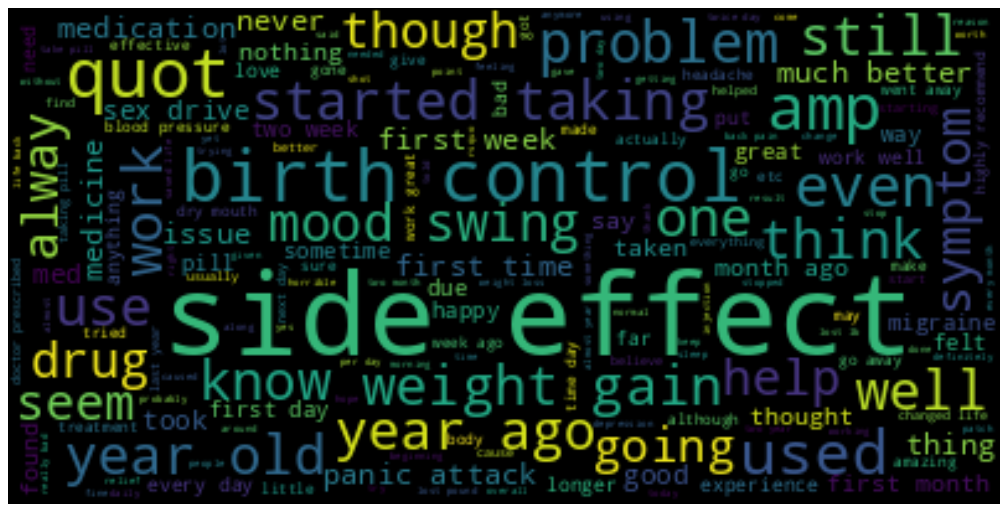

In [15]:
import matplotlib.pyplot as plt
import wordcloud
from matplotlib.pyplot import figure
figure(figsize=(16,12), dpi=80)
common_words=''
list = data_train[data_train.sentiment == 1]['text']
for i in list:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

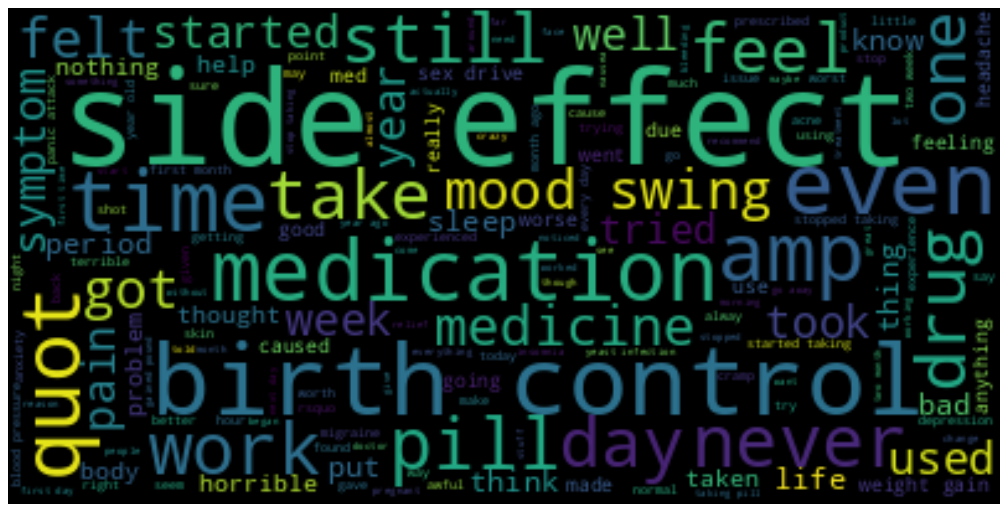

In [16]:
import matplotlib.pyplot as plt
import wordcloud
from matplotlib.pyplot import figure
figure(figsize=(16,12), dpi=80)
common_words=''
list = data_train[data_train.sentiment == -1]['text']
for i in list:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
len([x for x in data_train['review'] if len(x) > 1000])

320

Text(0.5, 0, 'Review Length')

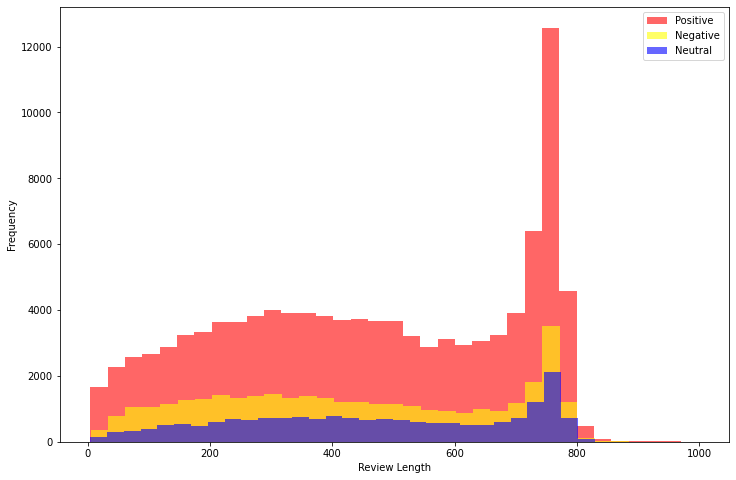

In [20]:
data_train['review_len'] = [len(x) for x in data_train['review']]
data_train = data_train[data_train.review_len < 1000]

plt.figure(figsize=(12, 8))
data_train[data_train.sentiment==1].review_len.plot(bins=35, kind='hist', color='red', 
                                       label='Positive', alpha=0.6)
data_train[data_train.sentiment==-1].review_len.plot(bins=35, kind='hist', color='yellow', 
                                       label='Negative', alpha=0.6)
data_train[data_train.sentiment==0].review_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Neutral', alpha=0.6)
plt.legend()
plt.xlabel("Review Length")